# Classification of Ice and Open Water in Nizhnesvirsky Lower Bay using Sentinel-1 IW Product

The Nizhnesvirsky lower bay is a vital part of a river system characterized by a dynamic freeze-thaw cycle. Understanding the extent of ice coverage and open water in this region is crucial for various applications, including navigation, ecosystem monitoring, and climate research. In this Jupyter notebook, we will leverage satellite imagery from the Sentinel-1 Interferometric Wide (IW) product, along with remote sensing principles, to classify ice and open water over a period of 8 months, from September 2022 to May 2023.

The Sentinel-1 satellite offers reliable and frequent radar imaging capabilities, making it ideal for monitoring ice and water bodies. The Sentinel-1 IW product provides Synthetic Aperture Radar (SAR) data, which is unaffected by weather conditions, daylight, or cloud cover. SAR data measures the backscattered electromagnetic waves, allowing us to distinguish between different surface types.

First, let us import all the necessary libraries.

In [1]:
import datetime
import getpass

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import geopandas as gpd
import json
from ipyleaflet import Map, GeoJSON, basemaps

from sentinelhub import (
    SHConfig,
    Geometry,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

### Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [ ]:
# config = SHConfig("profile_name")

### Defining the Bounds
We can define the bounds of the area of interest by considering a geojson file of the part of the river Svir.

In [ ]:
SHAPE_PATH = "./data/Nizhnesvirsky_lower_bay.geojson"
river_gdf = gpd.read_file(SHAPE_PATH)

# Convert to EPSG 3035
river_gdf = river_gdf.to_crs("EPSG:3035")
# Geometry of an entire area
resolution = 20

data = json.load(open(SHAPE_PATH, "r"))

# Set center and zoom level
center = [60.78, 33.68]
zoom = 12

# Add OSM background
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

# Add geojson data
geo_json = GeoJSON(data=data)
m.add_layer(geo_json)

# Display
m

Here, we can split the entire time period into 24 slots so that we can get 2 acquisitions every month to capture the freeze-thaw dynamics adequately.

In [4]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2023, 4, 30)
n_chunks = 17
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2022-09-01', '2022-09-15')
('2022-09-15', '2022-09-29')
('2022-09-29', '2022-10-13')
('2022-10-13', '2022-10-27')
('2022-10-27', '2022-11-10')
('2022-11-10', '2022-11-25')
('2022-11-25', '2022-12-09')
('2022-12-09', '2022-12-23')
('2022-12-23', '2023-01-06')
('2023-01-06', '2023-01-20')
('2023-01-20', '2023-02-03')
('2023-02-03', '2023-02-18')
('2023-02-18', '2023-03-04')
('2023-03-04', '2023-03-18')
('2023-03-18', '2023-04-01')
('2023-04-01', '2023-04-15')


### Requesting Sentinel-1 (SAR) Data
We now obtain Sentinel-1 IW SAR images covering the Nizhnesvirsky lower bay in the above mentioned time periods. An evalscript is used to describe the processing that needs to be performed on the SAR imagery. This script defines the input and output expected in the `setup()` function and `evaluatePixel()` function defines operations applied at the pixel level. 

Note 1: The default output sample type is 'AUTO'. In this case all the values between 0 to 1 are stretched to (0,255) and the values lying outside (0,1) are clipped.

The SAR imagery needs to be preprocessed before it can be used. The following pre-processing techniques must be performed to mitigate any noise and errors.
- Radiometric calibration to normalize the SAR image intensities (by setting the backscatter coefficient to `SIGMA0_ELLPSOID`).   
- Apply `LEE` speckle filtering techniques to reduce noise and enhance the visual quality of the images (Window size is set to `3x3`).   
- Apply geometric correction to ensure geometric accuracy and spatial alignment between the images (by applying `COPERNICUS` DEM).

The images are filtered according to the ascending orbit and the resolution is set to `HIGH` (20m x 20m)

Note 2: Here, we need to be careful about the units. THe units of geometry with WGS84 are degrees. To get a 20m resolution, the geometry must be transformed to `EPSG:3035`.

In [5]:
evalscript_sar = """
  function setup() {
    return {
      input: ["VV", "dataMask"],
      output: { bands: 2, sampleType: "FLOAT32"}                  // Refer to Note 1
    }
  }


// visualizes decibels from -20 to +10
function toDb(linear) {
  var log = 10 * Math.log(linear) / Math.LN10
  return Math.max(0, (log + 20) / 30)
}

function evaluatePixel(sample) {
  var VV = sample.VV;

  return [toDb(VV),sample.dataMask];
}
"""


def get_sar_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_sar,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    "s1iw", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                other_args={
                    "dataFilter": {
                        "resolution": "HIGH",
                        "mosaickingOrder": "mostRecent",
                        "orbitDirection": "ASCENDING",
                    },
                    "processing": {
                        "backCoeff": "SIGMA0_ELLIPSOID",
                        "orthorectify": True,
                        "demInstance": "COPERNICUS",
                        "speckleFilter": {
                            "type": "LEE",
                            "windowSizeX": 3,
                            "windowSizeY": 3,
                        },
                    },
                },
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=Geometry(river_gdf.geometry.values[0], crs=river_gdf.crs),
        resolution=[20, 20],  # Refer to Note 2
        config=config,
        data_folder="./results",
    )

We can create a list of all the requests for each of the time slots and run them together. 

In [6]:
# create a list of requests
list_of_requests = [get_sar_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

Below are a series of maps that show the SAR imagery in VV mode. This means that the electromagnetic waves are transmitted and received by the Radar on board Sentinel-1 are both oriented to the vertical plane. 

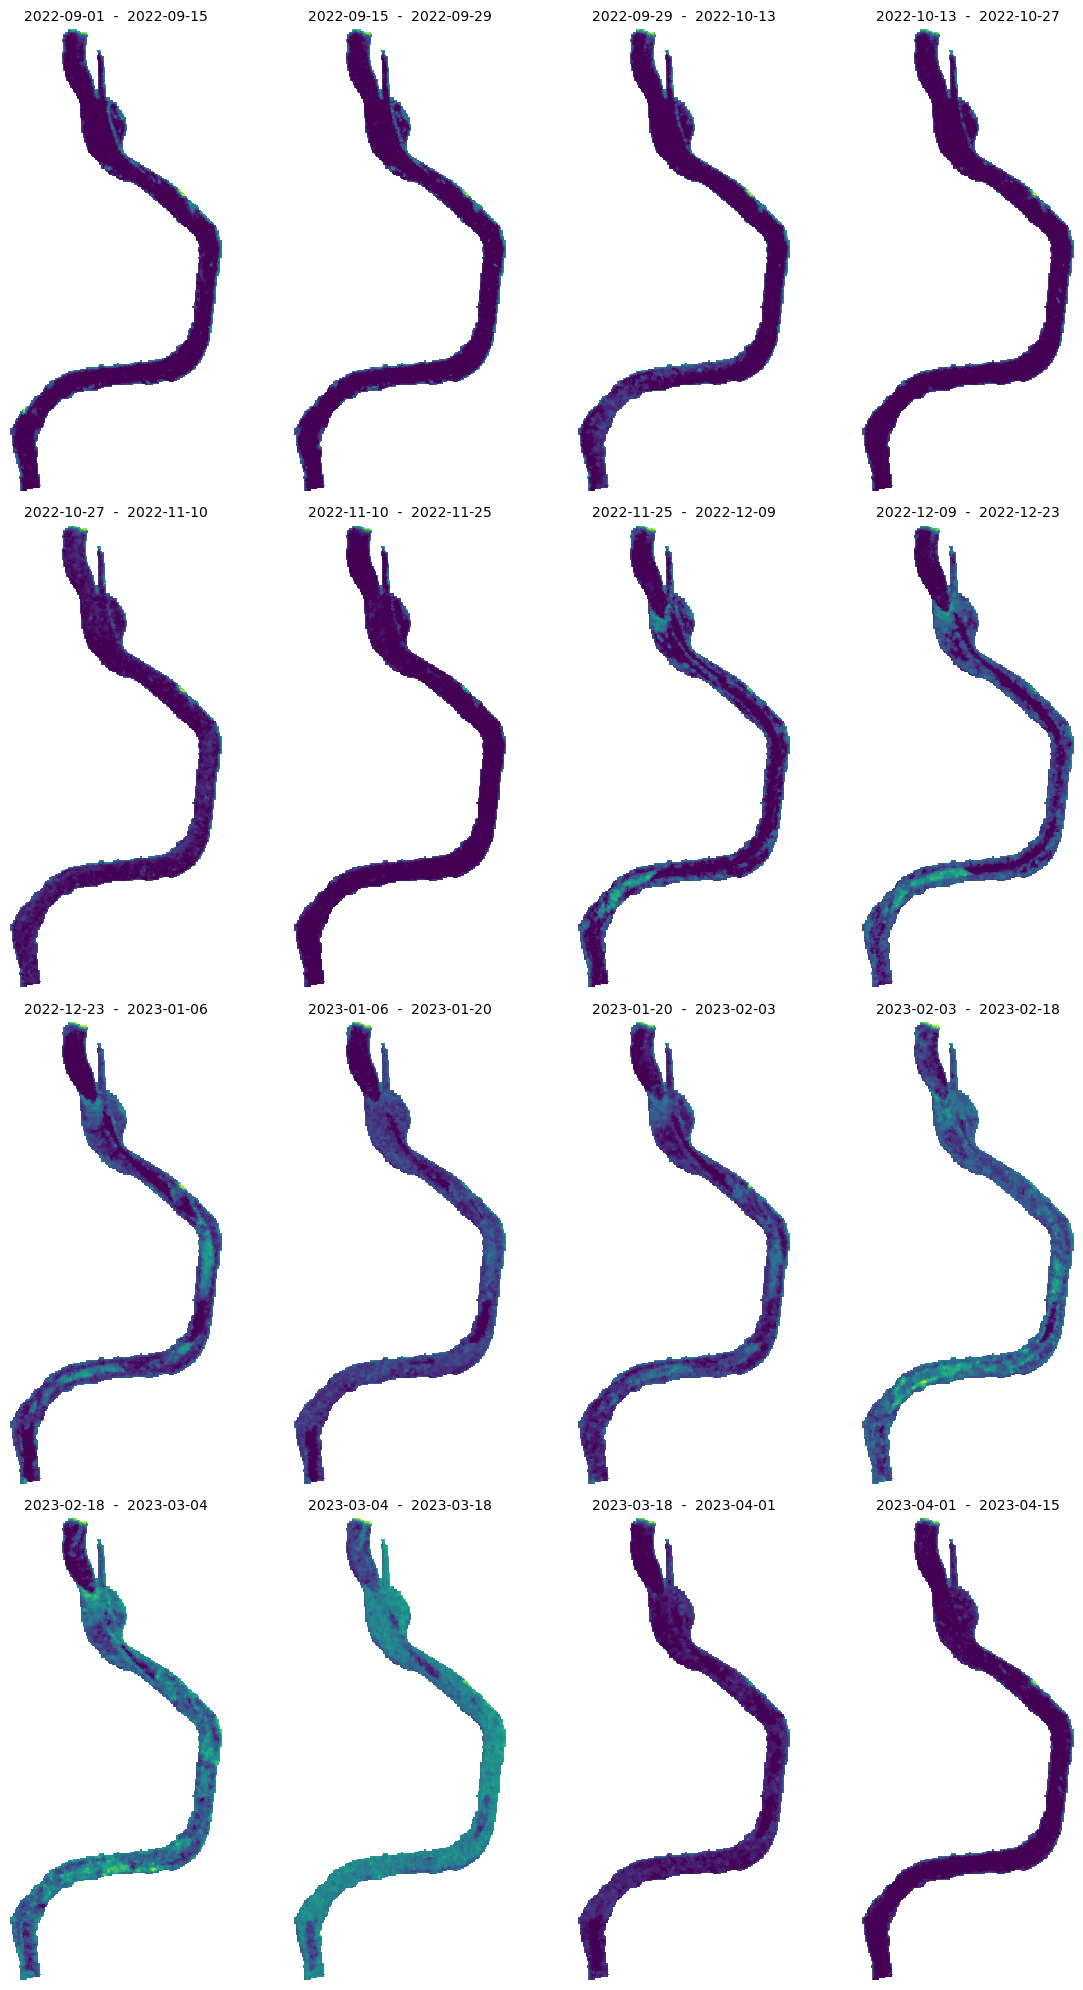

In [7]:
ncols = 4
nrows = 4
aspect_ratio = 1.5
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(2 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip((image[:, :, 0]) * 3.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

### Estimating a threshold
If we look at the images for all time slots, we can see that the pixels in the river become brighter as the winter months approach. This is because the water acts like a mirror and very little backscatter reaches the sensor. However, if there is a structure or disturbance in the water (in this case ice), the electromagnetic waves are scattered in all directions and the chance of detecting this backscatter is higher ([Reference](https://www.mdpi.com/remotesensing/remotesensing-12-02228/article_deploy/html/images/remotesensing-12-02228-g004-550.jpg)). It is possible that not all bright pixels are ice, which can be verified by in-situ measurements.

To determine what a good threshold would be to differentiate the water pixels from ice, we can plot the distribution of pixel values within the entire range `(0,255)`.

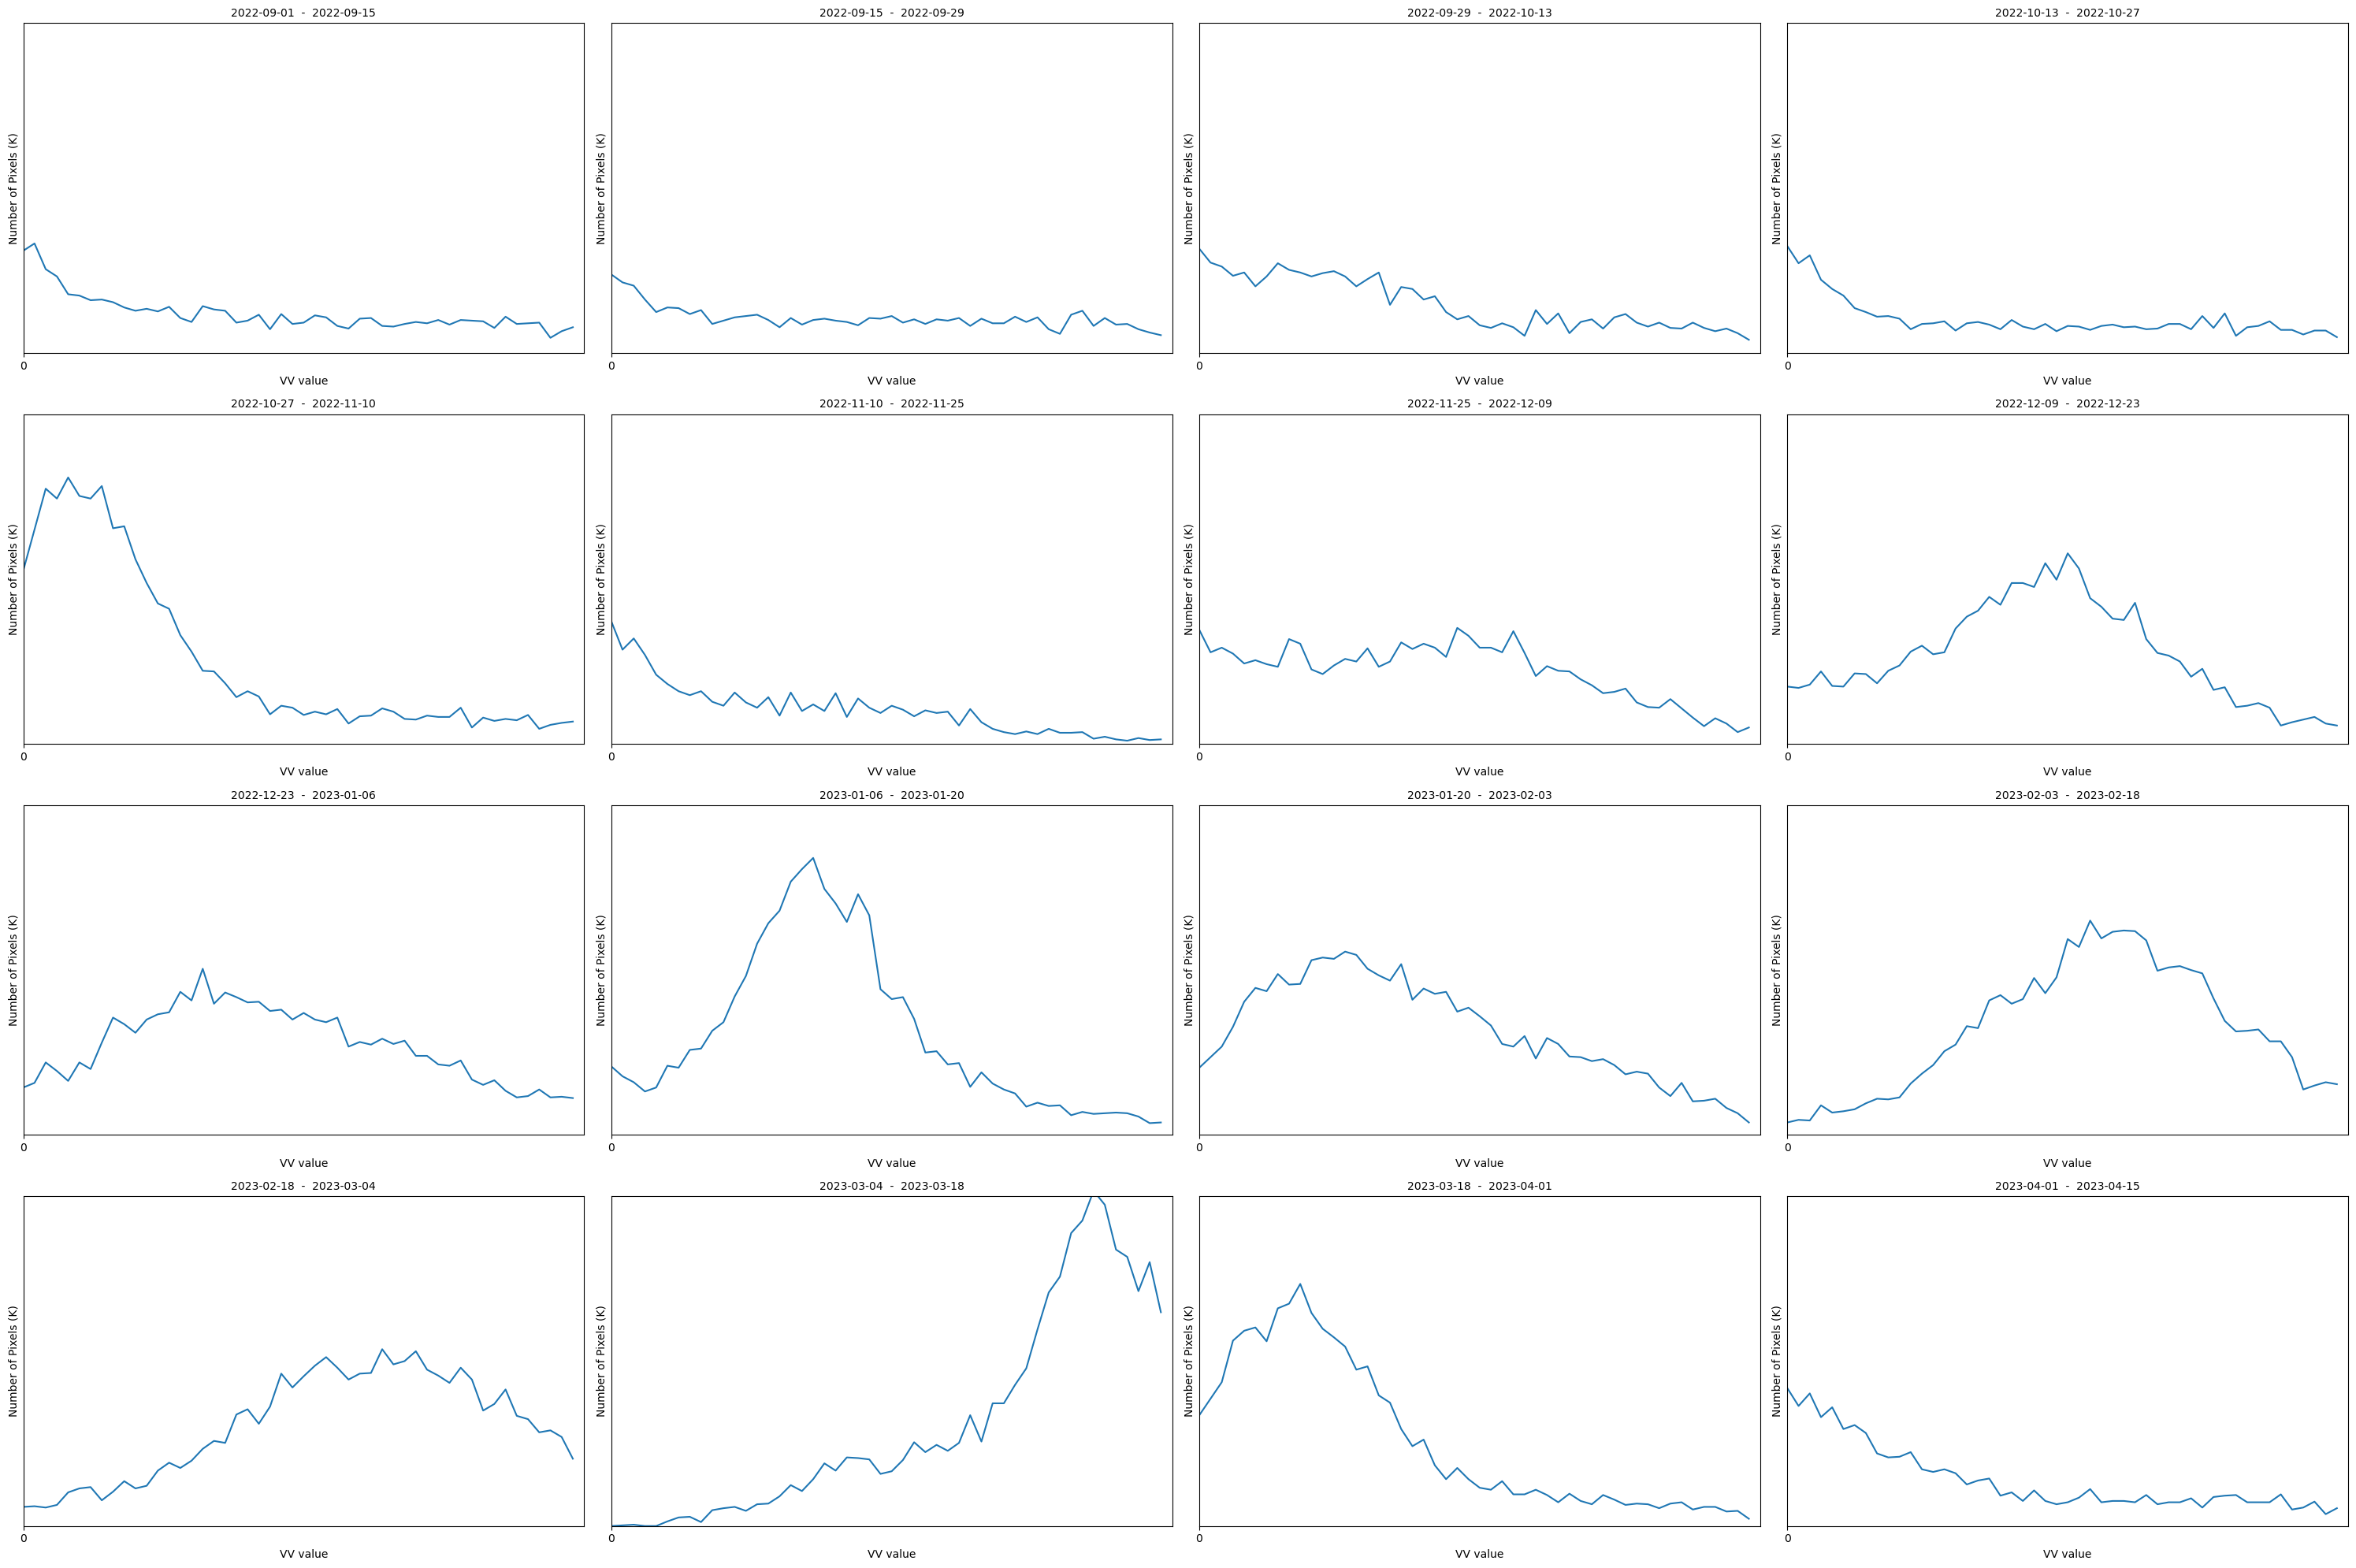

In [8]:
ncols = 4
nrows = 4
aspect_ratio = 15 / 10
subplot_kw = {"xticks": range(0, 255, 25), "yticks": [], "frame_on": True}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    histogram, bin_edges = np.histogram(
        2.5 * image[:, :, 0], bins=50, range=(0.0000001, 1)
    )
    ax = axs[idx // ncols][idx % ncols]
    ax.plot(bin_edges[0:-1], histogram)
    ax.set_xlabel("VV value")
    ax.set_ylabel("Number of Pixels (K)")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 500))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

Considering the historic [weather information](https://www.meteoblue.com/de/wetter/historyclimate/weatherarchive/svir%27stroy_russland_485557?fcstlength=1y&year=2022&month=5) of the region and interpreting the SAR imagery, we can see that the appearance of ice in the river Svir started at the end of November and continued on till mid-March. By looking at the distribution plots above, we can set a threshold at a pixel value 50.

The evalscript below creates a visualisation of the ice mask directly after processing the SAR data and checking for the threshold. If the pixel value is more than 50/255, then it is classified at an icy pixel and the `iceMask = 1`. 

In [9]:
evalscript_mask = """
  function setup() {
    return {
      input: ["VV", "dataMask"],
      output: { bands: 5 , sampleType: "UINT8"}
    }
  }

// visualizes decibels from -20 to +10
function toDb(linear) {
  var log = 10 * Math.log(linear) / Math.LN10
  return Math.max(0, (log + 20) / 30)
}

function evaluatePixel(sample) {
  var VV = sample.VV;
  var iceMask = 0;
  VVdB = toDb(VV);
  if (VVdB >-0.001 && VVdB < 0.2) {
    iceMask = 0;
    return [0, 0, 255, sample.dataMask, iceMask]; // Water mask
  } else if (VVdB > 0.2 && VVdB <1) {
    iceMask = 1;
    return [0, 255, 255,sample.dataMask, iceMask];
  } else {
  iceMask = 0;
  return [0,0,0,sample.dataMask,iceMask];
  }
}
"""


def get_ice_mask_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    "s1iw", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                other_args={
                    "dataFilter": {
                        "resolution": "HIGH",
                        "mosaickingOrder": "mostRecent",
                        "orbitDirection": "ASCENDING",
                    },
                    "processing": {
                        "backCoeff": "SIGMA0_ELLIPSOID",
                        "orthorectify": True,
                        "demInstance": "COPERNICUS",
                        "speckleFilter": {
                            "type": "LEE",
                            "windowSizeX": 3,
                            "windowSizeY": 3,
                        },
                    },
                },
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=Geometry(river_gdf.geometry.values[0], crs=river_gdf.crs),
        resolution=[20, 20],
        config=config,
        data_folder="./results_mask",
    )

In [10]:
# create a list of requests
list_of_requests = [get_ice_mask_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
mask_data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

The `mask_data` maps can be plotted as below to visualize the ice pixels and open water pixels. 

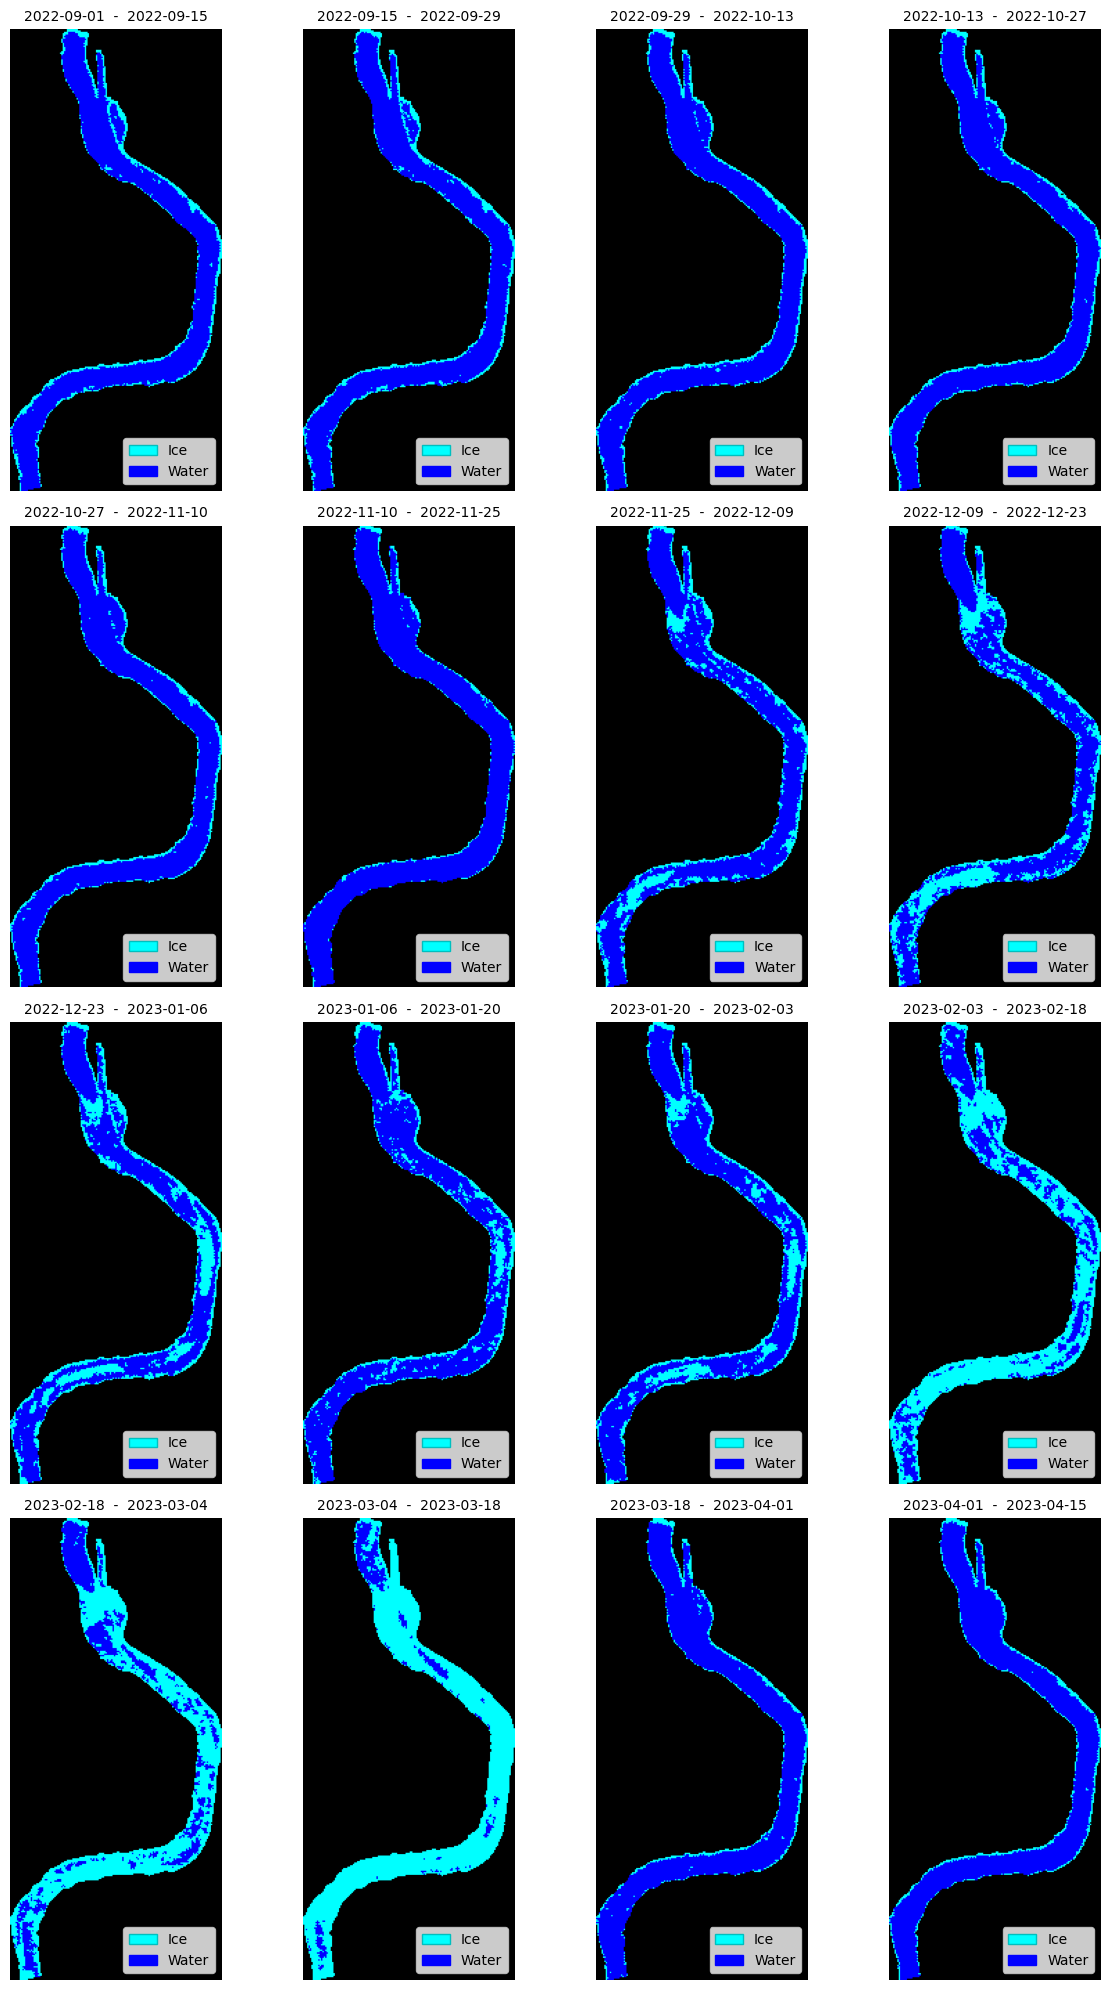

In [11]:
ncols = 4
nrows = 4
aspect_ratio = 1131 / 1819
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
legend_elements = [
    Patch(facecolor="cyan", edgecolor="c", label="Ice"),
    Patch(facecolor="blue", edgecolor="b", label="Water"),
]
fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(mask_data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip((image[:, :, :3]), 0, 255))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)
    ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()

### Creating a Timeseries of the area covered by ice

Next, we can claculate the area covered by ice by considering the number of pixels classified as ice and multiplying with the initial resolution of the downloaded image, which is 20m x 20m in our case. This is done by counting the number of pixels that have the value `1` in the `iceMask` band. 

In [12]:
def count_ice_pixels(image):
    ice_mask = image[:, :, 4]

    # Count the number of blue pixels
    ice_pixel_count = np.sum(ice_mask)

    # print(ice_pixel_count)

    return ice_pixel_count

In [13]:
resolution_s1 = 20 * 20  # meters
area_covered_ice = []
for idx, image in enumerate(mask_data):
    # Count the number of icy pixels
    ice_pixels_count = count_ice_pixels(image)
    area_covered_ice.append(ice_pixels_count * resolution_s1 / 1000000)

The calculated area can be plotted over time to determine the months with peak ice cover over the river.

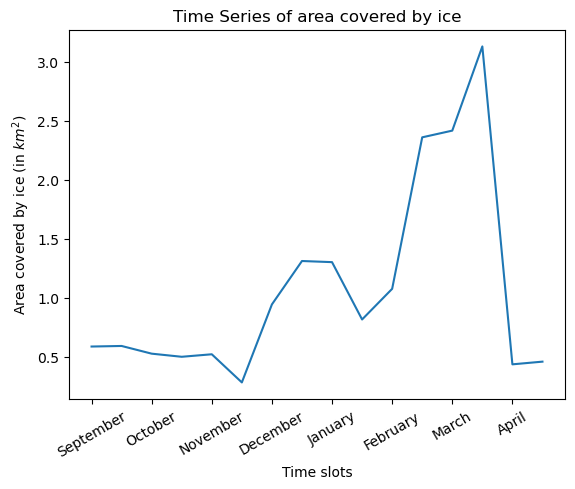

In [14]:
xlabels = [
    "September",
    "October",
    "November",
    "December",
    "January",
    "February",
    "March",
    "April",
]
x = range(len(slots))
plt.plot(range(len(slots)), area_covered_ice)
plt.title("Time Series of area covered by ice")
plt.xticks(np.arange(0, 16, step=2), xlabels, rotation=30, ha="center")
plt.xlabel("Time slots")
plt.ylabel("Area covered by ice (in $km^2$)")
plt.show()

This confirms the hypothesis of the ice formation beginning in mid-to-end of November and the amount of ice cover increasing as the winter progressed. We can also notice that once the ice starts breaking up in mid March, the ice clears out very quickly. 

### Summary 

- The classification results will provide temporal information about the freeze-thaw cycle in the Nizhnesvirsky lower bay.
- By analyzing the classified maps, we can observe the progression of ice formation, ice breakup, and the duration of open water periods.
- Quantitative analysis of ice coverage and open water duration can be derived from the classified maps, aiding in the assessment of seasonal changes and long-term trends.